In [1]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp/data/pair_embeddings/audio/train/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(1, 2048)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sklearn; print(sklearn.__version__)

1.2.2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
with open('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [6]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape


37081
7621


(tensor(4.8656), torch.Size([]))

In [7]:
pos_weight

tensor(4.8656)

In [8]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_audio.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float()

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,2055), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [10]:
input_size = 2055
hidden_size = 2048
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 4
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).float()) 

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_audio.pt')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.3488
Epoch [1/20], Batch [10/17], Loss: 1.2502
Epoch [1/20], Batch [15/17], Loss: 1.2176
Epoch 1/20, Loss: 1.2134
Epoch [2/20], Batch [5/17], Loss: 1.1070
Epoch [2/20], Batch [10/17], Loss: 1.0926
Epoch [2/20], Batch [15/17], Loss: 1.1349
Epoch 2/20, Loss: 1.1190
Epoch [3/20], Batch [5/17], Loss: 1.1112
Epoch [3/20], Batch [10/17], Loss: 1.1044
Epoch [3/20], Batch [15/17], Loss: 1.0646
Epoch 3/20, Loss: 1.1056
Epoch [4/20], Batch [5/17], Loss: 1.1010
Epoch [4/20], Batch [10/17], Loss: 1.0821
Epoch [4/20], Batch [15/17], Loss: 1.1249
Epoch 4/20, Loss: 1.1015
Epoch [5/20], Batch [5/17], Loss: 1.1325
Epoch [5/20], Batch [10/17], Loss: 1.0558
Epoch [5/20], Batch [15/17], Loss: 1.0257
Epoch 5/20, Loss: 1.0884
Epoch [6/20], Batch [5/17], Loss: 1.1093
Epoch [6/20], Batch [10/17], Loss: 1.1345
Epoch [6/20], Batch [15/17], Loss: 1.0726
Epoch 6/20, Loss: 1.0801
Epoch [7/20], Batch [5/17], Loss: 1.1242
Epoch [7/20], Batch [10/17], Loss: 1.0635
Epoch [7/20], Bat

In [10]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels


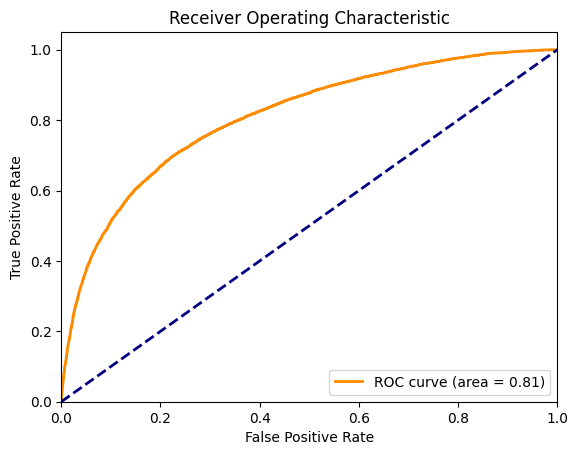

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/train'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.3939490020275116


In [11]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()

            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return average_loss, accuracy, precision, recall, f1_score

In [15]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

True Positives: 1384
False Positives: 2835
False Negatives: 409
True Negatives: 5704
Total samples: 10332
Test Loss: 0.9243, Test Accuracy: 0.6860, Precision: 0.3280, Recall: 0.7719, F1 Score: 0.4604


For pos_w: 4.8


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.6862
Epoch [1/20], Batch [10/17], Loss: 1.2905
Epoch [1/20], Batch [15/17], Loss: 1.2930
Epoch 1/20, Loss: 1.3471
Epoch [2/20], Batch [5/17], Loss: 1.1201
Epoch [2/20], Batch [10/17], Loss: 1.2100
Epoch [2/20], Batch [15/17], Loss: 1.2119
Epoch 2/20, Loss: 1.1359
Epoch [3/20], Batch [5/17], Loss: 1.1580
Epoch [3/20], Batch [10/17], Loss: 1.1451
Epoch [3/20], Batch [15/17], Loss: 1.0927
Epoch 3/20, Loss: 1.1131
Epoch [4/20], Batch [5/17], Loss: 1.0754
Epoch [4/20], Batch [10/17], Loss: 1.1394
Epoch [4/20], Batch [15/17], Loss: 1.0889
Epoch 4/20, Loss: 1.1039
Epoch [5/20], Batch [5/17], Loss: 1.0984
Epoch [5/20], Batch [10/17], Loss: 1.0427
Epoch [5/20], Batch [15/17], Loss: 1.0401
Epoch 5/20, Loss: 1.0912
Epoch [6/20], Batch [5/17], Loss: 1.0683
Epoch [6/20], Batch [10/17], Loss: 1.0792
Epoch [6/20], Batch [15/17], Loss: 1.1156
Epoch 6/20, Loss: 1.0802
Epoch [7/20], Batch [5/17], Loss: 1.1071
Epoch [7/20], Batch [10/17], Loss: 1.0866
Epoch [7/20], Bat

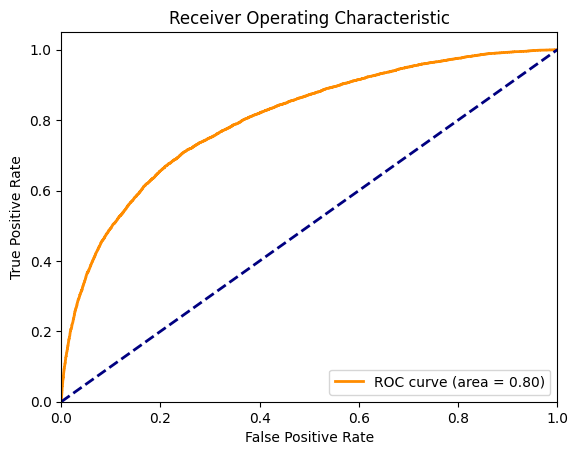

Optimal threshold: 0.4628809988498688
True Positives: 1403
False Positives: 3341
False Negatives: 390
True Negatives: 5198
Total samples: 10332
For pos_weight: 4.8 ---> Test Loss: 0.9350, Test Accuracy: 0.6389, Precision: 0.2957, Recall: 0.7825, F1 Score: 0.4292
For pos_w: 4.7


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.6762
Epoch [1/20], Batch [10/17], Loss: 1.3735
Epoch [1/20], Batch [15/17], Loss: 1.2025
Epoch 1/20, Loss: 1.3528
Epoch [2/20], Batch [5/17], Loss: 1.1954
Epoch [2/20], Batch [10/17], Loss: 1.1182
Epoch [2/20], Batch [15/17], Loss: 1.0970
Epoch 2/20, Loss: 1.1254
Epoch [3/20], Batch [5/17], Loss: 1.0602
Epoch [3/20], Batch [10/17], Loss: 1.1561
Epoch [3/20], Batch [15/17], Loss: 1.0712
Epoch 3/20, Loss: 1.0999
Epoch [4/20], Batch [5/17], Loss: 1.0431
Epoch [4/20], Batch [10/17], Loss: 1.1206
Epoch [4/20], Batch [15/17], Loss: 1.0400
Epoch 4/20, Loss: 1.0889
Epoch [5/20], Batch [5/17], Loss: 1.0549
Epoch [5/20], Batch [10/17], Loss: 1.1087
Epoch [5/20], Batch [15/17], Loss: 1.0519
Epoch 5/20, Loss: 1.0740
Epoch [6/20], Batch [5/17], Loss: 1.0615
Epoch [6/20], Batch [10/17], Loss: 1.1073
Epoch [6/20], Batch [15/17], Loss: 1.0782
Epoch 6/20, Loss: 1.0654
Epoch [7/20], Batch [5/17], Loss: 1.0232
Epoch [7/20], Batch [10/17], Loss: 1.0932
Epoch [7/20], Bat

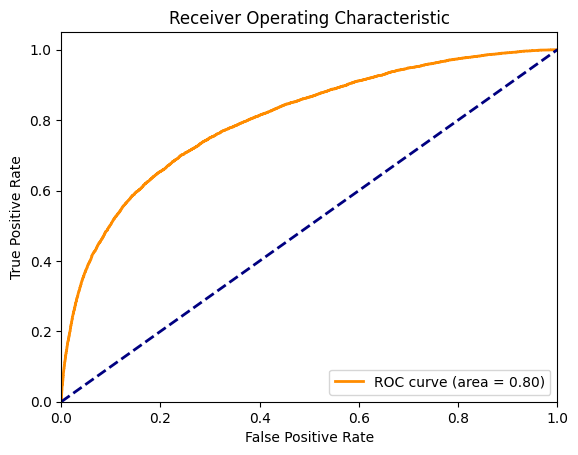

Optimal threshold: 0.5610795617103577
True Positives: 1383
False Positives: 3158
False Negatives: 410
True Negatives: 5381
Total samples: 10332
For pos_weight: 4.7 ---> Test Loss: 0.9559, Test Accuracy: 0.6547, Precision: 0.3046, Recall: 0.7713, F1 Score: 0.4367
For pos_w: 4.6


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.5896
Epoch [1/20], Batch [10/17], Loss: 1.3096
Epoch [1/20], Batch [15/17], Loss: 1.2418
Epoch 1/20, Loss: 1.3094
Epoch [2/20], Batch [5/17], Loss: 1.1200
Epoch [2/20], Batch [10/17], Loss: 1.1793
Epoch [2/20], Batch [15/17], Loss: 1.1004
Epoch 2/20, Loss: 1.1142
Epoch [3/20], Batch [5/17], Loss: 1.0693
Epoch [3/20], Batch [10/17], Loss: 1.0734
Epoch [3/20], Batch [15/17], Loss: 1.0621
Epoch 3/20, Loss: 1.0843
Epoch [4/20], Batch [5/17], Loss: 1.1041
Epoch [4/20], Batch [10/17], Loss: 1.0659
Epoch [4/20], Batch [15/17], Loss: 1.0423
Epoch 4/20, Loss: 1.0718
Epoch [5/20], Batch [5/17], Loss: 1.0262
Epoch [5/20], Batch [10/17], Loss: 1.0669
Epoch [5/20], Batch [15/17], Loss: 1.0026
Epoch 5/20, Loss: 1.0637
Epoch [6/20], Batch [5/17], Loss: 1.0733
Epoch [6/20], Batch [10/17], Loss: 1.0588
Epoch [6/20], Batch [15/17], Loss: 1.0720
Epoch 6/20, Loss: 1.0572
Epoch [7/20], Batch [5/17], Loss: 1.1110
Epoch [7/20], Batch [10/17], Loss: 1.0267
Epoch [7/20], Bat

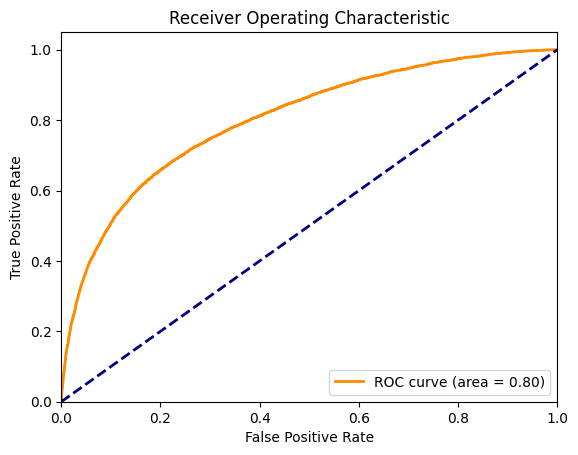

Optimal threshold: 0.5782303214073181
True Positives: 1348
False Positives: 2992
False Negatives: 445
True Negatives: 5547
Total samples: 10332
For pos_weight: 4.6 ---> Test Loss: 0.9543, Test Accuracy: 0.6673, Precision: 0.3106, Recall: 0.7518, F1 Score: 0.4396
For pos_w: 4.5


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.5711
Epoch [1/20], Batch [10/17], Loss: 1.2547
Epoch [1/20], Batch [15/17], Loss: 1.1570
Epoch 1/20, Loss: 1.2753
Epoch [2/20], Batch [5/17], Loss: 1.1005
Epoch [2/20], Batch [10/17], Loss: 1.1335
Epoch [2/20], Batch [15/17], Loss: 1.0465
Epoch 2/20, Loss: 1.0938
Epoch [3/20], Batch [5/17], Loss: 1.0576
Epoch [3/20], Batch [10/17], Loss: 1.0849
Epoch [3/20], Batch [15/17], Loss: 1.0568
Epoch 3/20, Loss: 1.0625
Epoch [4/20], Batch [5/17], Loss: 1.0322
Epoch [4/20], Batch [10/17], Loss: 1.1012
Epoch [4/20], Batch [15/17], Loss: 1.1370
Epoch 4/20, Loss: 1.0602
Epoch [5/20], Batch [5/17], Loss: 1.0049
Epoch [5/20], Batch [10/17], Loss: 1.1036
Epoch [5/20], Batch [15/17], Loss: 1.0432
Epoch 5/20, Loss: 1.0556
Epoch [6/20], Batch [5/17], Loss: 1.0387
Epoch [6/20], Batch [10/17], Loss: 1.0554
Epoch [6/20], Batch [15/17], Loss: 1.0879
Epoch 6/20, Loss: 1.0498
Epoch [7/20], Batch [5/17], Loss: 1.0142
Epoch [7/20], Batch [10/17], Loss: 1.0387
Epoch [7/20], Bat

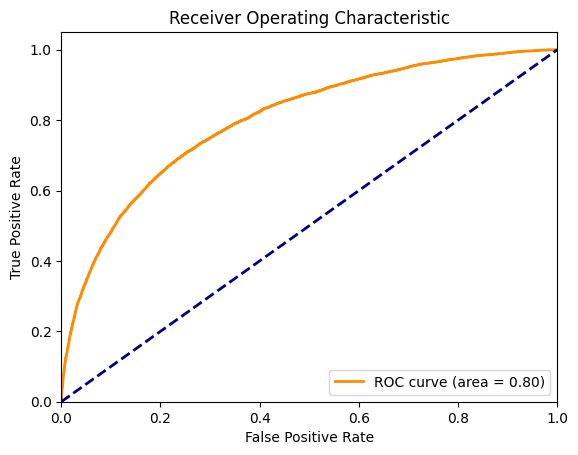

Optimal threshold: 0.5375770926475525
True Positives: 1447
False Positives: 3712
False Negatives: 346
True Negatives: 4827
Total samples: 10332
For pos_weight: 4.5 ---> Test Loss: 0.9573, Test Accuracy: 0.6072, Precision: 0.2805, Recall: 0.8070, F1 Score: 0.4163
For pos_w: 4.4


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.4290
Epoch [1/20], Batch [10/17], Loss: 1.1935
Epoch [1/20], Batch [15/17], Loss: 1.1696
Epoch 1/20, Loss: 1.2413
Epoch [2/20], Batch [5/17], Loss: 1.0123
Epoch [2/20], Batch [10/17], Loss: 1.0759
Epoch [2/20], Batch [15/17], Loss: 0.9849
Epoch 2/20, Loss: 1.0725
Epoch [3/20], Batch [5/17], Loss: 1.0749
Epoch [3/20], Batch [10/17], Loss: 1.0548
Epoch [3/20], Batch [15/17], Loss: 1.0394
Epoch 3/20, Loss: 1.0552
Epoch [4/20], Batch [5/17], Loss: 1.0278
Epoch [4/20], Batch [10/17], Loss: 1.0528
Epoch [4/20], Batch [15/17], Loss: 1.0543
Epoch 4/20, Loss: 1.0447
Epoch [5/20], Batch [5/17], Loss: 1.0215
Epoch [5/20], Batch [10/17], Loss: 1.0108
Epoch [5/20], Batch [15/17], Loss: 1.0602
Epoch 5/20, Loss: 1.0337
Epoch [6/20], Batch [5/17], Loss: 1.0309
Epoch [6/20], Batch [10/17], Loss: 1.0552
Epoch [6/20], Batch [15/17], Loss: 0.9609
Epoch 6/20, Loss: 1.0181
Epoch [7/20], Batch [5/17], Loss: 0.9961
Epoch [7/20], Batch [10/17], Loss: 0.9519
Epoch [7/20], Bat

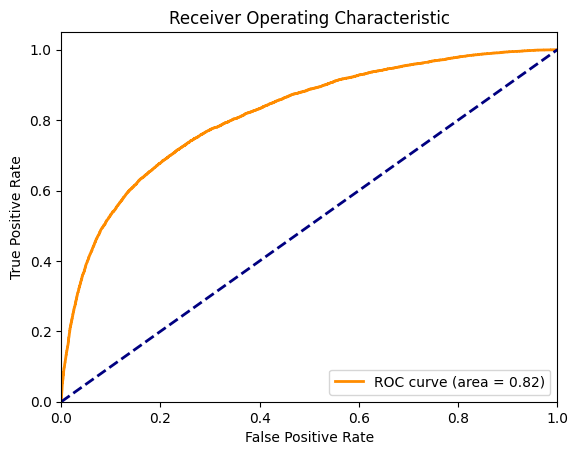

Optimal threshold: 0.5330159068107605
True Positives: 1362
False Positives: 3098
False Negatives: 431
True Negatives: 5441
Total samples: 10332
For pos_weight: 4.4 ---> Test Loss: 0.9155, Test Accuracy: 0.6584, Precision: 0.3054, Recall: 0.7596, F1 Score: 0.4356
For pos_w: 4.3


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.5121
Epoch [1/20], Batch [10/17], Loss: 1.3050
Epoch [1/20], Batch [15/17], Loss: 1.1578
Epoch 1/20, Loss: 1.3229
Epoch [2/20], Batch [5/17], Loss: 1.1410
Epoch [2/20], Batch [10/17], Loss: 1.0524
Epoch [2/20], Batch [15/17], Loss: 1.0626
Epoch 2/20, Loss: 1.0726
Epoch [3/20], Batch [5/17], Loss: 1.0401
Epoch [3/20], Batch [10/17], Loss: 1.0385
Epoch [3/20], Batch [15/17], Loss: 0.9570
Epoch 3/20, Loss: 1.0541
Epoch [4/20], Batch [5/17], Loss: 1.0018
Epoch [4/20], Batch [10/17], Loss: 1.0080
Epoch [4/20], Batch [15/17], Loss: 1.0274
Epoch 4/20, Loss: 1.0451
Epoch [5/20], Batch [5/17], Loss: 1.0655
Epoch [5/20], Batch [10/17], Loss: 1.0395
Epoch [5/20], Batch [15/17], Loss: 1.0133
Epoch 5/20, Loss: 1.0316
Epoch [6/20], Batch [5/17], Loss: 0.9926
Epoch [6/20], Batch [10/17], Loss: 0.9898
Epoch [6/20], Batch [15/17], Loss: 1.0455
Epoch 6/20, Loss: 1.0246
Epoch [7/20], Batch [5/17], Loss: 1.0167
Epoch [7/20], Batch [10/17], Loss: 1.0043
Epoch [7/20], Bat

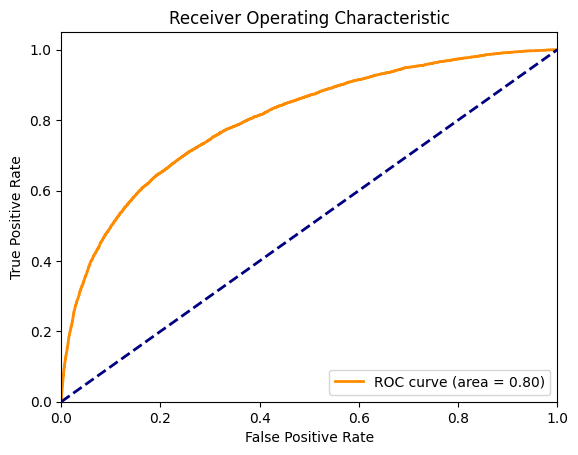

Optimal threshold: 0.572979211807251
True Positives: 1367
False Positives: 3156
False Negatives: 426
True Negatives: 5383
Total samples: 10332
For pos_weight: 4.3 ---> Test Loss: 0.9303, Test Accuracy: 0.6533, Precision: 0.3022, Recall: 0.7624, F1 Score: 0.4329
For pos_w: 4.2


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.3533
Epoch [1/20], Batch [10/17], Loss: 1.2183
Epoch [1/20], Batch [15/17], Loss: 1.1009
Epoch 1/20, Loss: 1.1873
Epoch [2/20], Batch [5/17], Loss: 1.0483
Epoch [2/20], Batch [10/17], Loss: 1.0128
Epoch [2/20], Batch [15/17], Loss: 1.0087
Epoch 2/20, Loss: 1.0589
Epoch [3/20], Batch [5/17], Loss: 1.0170
Epoch [3/20], Batch [10/17], Loss: 1.0591
Epoch [3/20], Batch [15/17], Loss: 1.0289
Epoch 3/20, Loss: 1.0420
Epoch [4/20], Batch [5/17], Loss: 1.0193
Epoch [4/20], Batch [10/17], Loss: 1.0194
Epoch [4/20], Batch [15/17], Loss: 1.0516
Epoch 4/20, Loss: 1.0230
Epoch [5/20], Batch [5/17], Loss: 1.0355
Epoch [5/20], Batch [10/17], Loss: 1.0138
Epoch [5/20], Batch [15/17], Loss: 0.9914
Epoch 5/20, Loss: 1.0112
Epoch [6/20], Batch [5/17], Loss: 1.0174
Epoch [6/20], Batch [10/17], Loss: 0.9690
Epoch [6/20], Batch [15/17], Loss: 1.0009
Epoch 6/20, Loss: 0.9999
Epoch [7/20], Batch [5/17], Loss: 0.9326
Epoch [7/20], Batch [10/17], Loss: 0.9611
Epoch [7/20], Bat

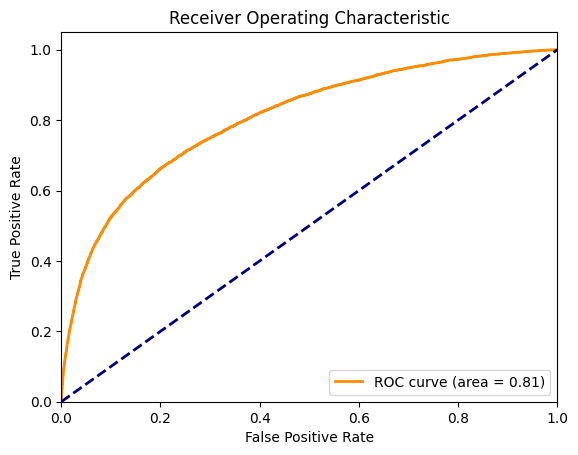

Optimal threshold: 0.42342549562454224
True Positives: 1304
False Positives: 2386
False Negatives: 489
True Negatives: 6153
Total samples: 10332
For pos_weight: 4.2 ---> Test Loss: 0.8547, Test Accuracy: 0.7217, Precision: 0.3534, Recall: 0.7273, F1 Score: 0.4757
For pos_w: 4.1


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1405
Epoch [1/20], Batch [10/17], Loss: 1.0317
Epoch [1/20], Batch [15/17], Loss: 1.0035
Epoch 1/20, Loss: 1.1645
Epoch [2/20], Batch [5/17], Loss: 1.0328
Epoch [2/20], Batch [10/17], Loss: 1.0331
Epoch [2/20], Batch [15/17], Loss: 1.0355
Epoch 2/20, Loss: 1.0276
Epoch [3/20], Batch [5/17], Loss: 0.9841
Epoch [3/20], Batch [10/17], Loss: 1.0269
Epoch [3/20], Batch [15/17], Loss: 1.0110
Epoch 3/20, Loss: 1.0125
Epoch [4/20], Batch [5/17], Loss: 1.0094
Epoch [4/20], Batch [10/17], Loss: 0.9795
Epoch [4/20], Batch [15/17], Loss: 1.0229
Epoch 4/20, Loss: 1.0046
Epoch [5/20], Batch [5/17], Loss: 0.9769
Epoch [5/20], Batch [10/17], Loss: 0.9907
Epoch [5/20], Batch [15/17], Loss: 0.9794
Epoch 5/20, Loss: 0.9914
Epoch [6/20], Batch [5/17], Loss: 0.9609
Epoch [6/20], Batch [10/17], Loss: 1.0075
Epoch [6/20], Batch [15/17], Loss: 0.9379
Epoch 6/20, Loss: 0.9749
Epoch [7/20], Batch [5/17], Loss: 1.0104
Epoch [7/20], Batch [10/17], Loss: 0.8869
Epoch [7/20], Bat

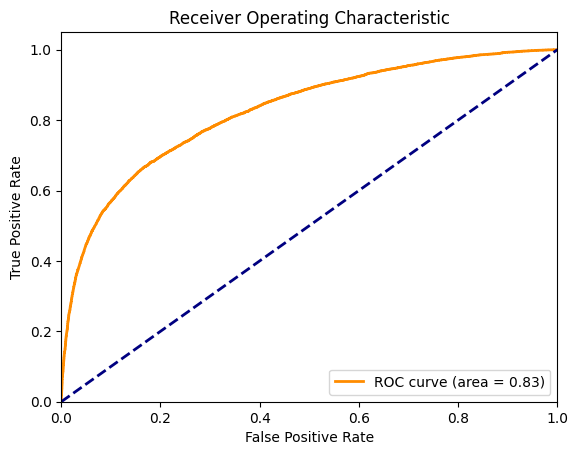

Optimal threshold: 0.393667608499527
True Positives: 1306
False Positives: 2392
False Negatives: 487
True Negatives: 6147
Total samples: 10332
For pos_weight: 4.1 ---> Test Loss: 0.8289, Test Accuracy: 0.7214, Precision: 0.3532, Recall: 0.7284, F1 Score: 0.4757
For pos_w: 4.0


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.2559
Epoch [1/20], Batch [10/17], Loss: 1.1146
Epoch [1/20], Batch [15/17], Loss: 1.0154
Epoch 1/20, Loss: 1.2015
Epoch [2/20], Batch [5/17], Loss: 1.0353
Epoch [2/20], Batch [10/17], Loss: 1.0218
Epoch [2/20], Batch [15/17], Loss: 1.0399
Epoch 2/20, Loss: 1.0278
Epoch [3/20], Batch [5/17], Loss: 1.0528
Epoch [3/20], Batch [10/17], Loss: 1.0531
Epoch [3/20], Batch [15/17], Loss: 0.9743
Epoch 3/20, Loss: 1.0049
Epoch [4/20], Batch [5/17], Loss: 0.9597
Epoch [4/20], Batch [10/17], Loss: 0.9941
Epoch [4/20], Batch [15/17], Loss: 0.9899
Epoch 4/20, Loss: 0.9979
Epoch [5/20], Batch [5/17], Loss: 0.9796
Epoch [5/20], Batch [10/17], Loss: 1.0023
Epoch [5/20], Batch [15/17], Loss: 0.9897
Epoch 5/20, Loss: 0.9907
Epoch [6/20], Batch [5/17], Loss: 0.9652
Epoch [6/20], Batch [10/17], Loss: 1.0162
Epoch [6/20], Batch [15/17], Loss: 1.0286
Epoch 6/20, Loss: 0.9768
Epoch [7/20], Batch [5/17], Loss: 1.0004
Epoch [7/20], Batch [10/17], Loss: 0.9782
Epoch [7/20], Bat

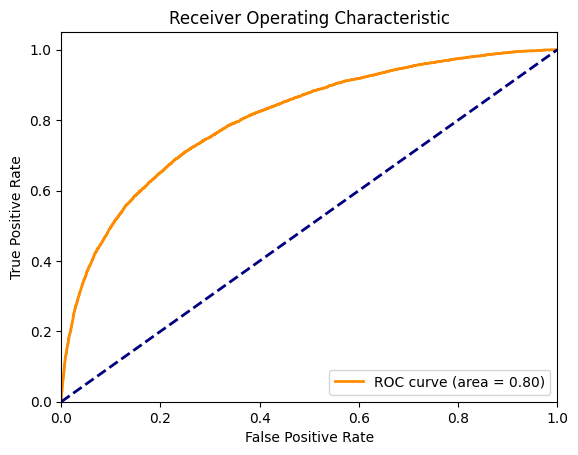

Optimal threshold: 0.4373834729194641
True Positives: 1402
False Positives: 3486
False Negatives: 391
True Negatives: 5053
Total samples: 10332
For pos_weight: 4.0 ---> Test Loss: 0.8591, Test Accuracy: 0.6248, Precision: 0.2868, Recall: 0.7819, F1 Score: 0.4197


In [14]:
pos_ws = [4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 2055
    hidden_size = 2048
    num_classes = 1
    lr = 2e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 4
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_audio.pt')

    
    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/audio/test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class PairDetectorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(PairDetectorMLP, self).__init__()
        self.mlp = MLP(input_dim, hidden_dim, num_classes)

    def forward(self, context_embeddings):
        return self.mlp(context_embeddings)

input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-3
batch_size = 64
num_epochs = 1
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetectorMLP(input_size, hidden_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_text.pt')

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch

            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            loss = criterion(output, target_pairs)

            total_loss += loss.item()
            total_samples += target_pairs.size(0)

    average_loss = total_loss / len(dataloader)

    return average_loss

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

val_loss = evaluate_model(model, test_dataloader, criterion)
print(f'Validation Loss: {val_loss:.4f}')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error loading item 119: Sizes of tensors must match except in dimension 0. Expected size 1543 but got size 2055 for tensor number 2 in the list.


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1543 but got size 2055 for tensor number 2 in the list.